## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression\

import pandas as pd
import numpy as np
import boto3
import awswrangler
from scipy.stats import chi2_contingency
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss
from math import sqrt

## Calling csv files used for analysis

In [2]:
libraries = pd.read_csv("libraries.csv")
checkouts = pd.read_csv("checkouts.csv")
customers = pd.read_csv("customers.csv")
books = pd.read_csv("books.csv")

## Joining tables using primary key and foregin key

In [3]:
lib_check = pd.merge(left=libraries, right=checkouts, left_on='id', right_on='library_id')
table1 = pd.merge(left=lib_check, right=customers, left_on='patron_id', right_on='id')
table2 = pd.merge(left=table1, right=books, left_on='id_y', right_on='id')

In [4]:
##table2.head()

In [5]:
table2.columns

Index(['id_x', 'name_x', 'street_address_x', 'city_x', 'region', 'postal_code',
       'id_y', 'patron_id', 'library_id', 'date_checkout', 'date_returned',
       'id_x', 'name_y', 'street_address_y', 'city_y', 'state', 'zipcode',
       'birth_date', 'gender', 'education', 'occupation', 'id_y', 'title',
       'authors', 'publisher', 'publishedDate', 'categories', 'price',
       'pages'],
      dtype='object')

## Data Cleaning

#### Dropping city and region because they contains all the values as Portland and Oregon respectively. Hence it is of no use in predicing depened variable so dropping those columns

In [6]:
table2 = table2.drop(columns=["city_x","city_y","state","region","street_address_y","street_address_x","library_id"])

In [7]:
table2 = table2.dropna(subset=["date_checkout","date_returned"])

In [8]:
import datetime
table2['date_returned'] = pd.to_datetime(table2['date_returned'],errors='coerce')
table2['date_checkout'] = pd.to_datetime(table2['date_checkout'],errors='coerce')

#### Calculating age from birth_date columns and then making categories based on age range


In [9]:
table2['birth_date'] = table2['birth_date'].str[:4]
table2['birth_date'] = table2['birth_date'].astype('float').astype('Int32')

In [10]:
table2['age'] = 2021 - table2['birth_date']
age_bins = np.arange(10,121,10)

labels= ['10-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100','101-110','111-120']
table2['age_group'] = pd.cut(table2.age, bins=age_bins, labels=labels, right=True)

labels= np.arange(1, 12)
table2['age_group_number'] = pd.cut(table2.age, bins=age_bins, labels=labels, right=True)
table2= table2.drop(columns=["birth_date","age","age_group"])

In [11]:
val = np.ravel(table2.age_group_number.values)
val = val[~np.isnan(val)]


In [12]:
table2.age_group_number = table2.age_group_number.fillna(random.choice(val))

#### Cleaning gender table as it contains different names for same entity

In [13]:
table2.loc[(table2.gender == 'male'),'gender']='M'
table2.loc[(table2.gender == 'male '),'gender']='M'
table2.loc[(table2.gender == 'MALE'),'gender']='M'
table2.loc[(table2.gender == ' male'),'gender']='M'
table2.loc[(table2.gender == 'female'),'gender']='F'
table2.loc[(table2.gender == ' female'),'gender']='F'
table2.loc[(table2.gender == 'female '),'gender']='M'
table2.loc[(table2.gender == 'FEMALE'),'gender']='M'

In [14]:
table2.gender.unique()

array(['M', 'F', nan], dtype=object)

#### dropping null values for the columns date_checkout and date_returned

In [15]:
table2 = table2.dropna(subset=["date_checkout","date_returned"])

## Making new is_late column to show whether the book has been returned late or not

In [16]:
table2["no_of_days"] = table2["date_returned"]-table2["date_checkout"]
table2['no_of_days'] = table2['no_of_days'].dt.days.astype('int16')
table2["legit"]= np.where(table2["no_of_days"]>=0, 1, 0)
table2["is_late"]= np.where(table2["no_of_days"]>=28, 1, 0)

#### Cleaning education column

In [17]:
table2['education'] =table2['education'].str.upper()
table2['education'] = table2['education'].str.strip()

In [18]:
table2.is_late.value_counts()

0    1554
1     291
Name: is_late, dtype: int64

#### The above statistics shows that data is imbalanced as there are more number of rows having is_late = 0 i.e. people have returned books on time and they are not late. 

### Cleaning price, pages and zipcode columns. Removing all the irrelevant symbols present in the date

In [19]:
table2["price"] = table2["price"].str.extract(r'(\d+)', expand=False)
table2["pages"] = table2["pages"].str.extract(r'(\d+)', expand=False)
#table2["postal_code"] = table2["postal_code"].str.extract(r'(\d+)', expand=False)
table2["zipcode"] = table2["zipcode"].str.extract(r'(\d+)', expand=False)

In [20]:
table2['price'] = table2['price'].fillna(0).astype(np.int64, errors='ignore')
table2['postal_code'] = table2['postal_code'].fillna(0).astype(np.int64, errors='ignore')

In [21]:
table2 = table2.dropna(subset=["zipcode"])

## Handling NULL values

In [22]:
table2.zipcode

0       97224
2       97223
3       97225
4       97201
5       97229
        ...  
1994    97202
1995    97227
1996    97233
1997    97211
1998    97217
Name: zipcode, Length: 1844, dtype: object

In [23]:
table2.price.fillna(value=table2['price'].mean(), inplace=True)
table2.zipcode.fillna(value=table2['zipcode'].mode(), inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


#### Replacing it with mean for price column and median for zipcode column

## Data Exploration

<AxesSubplot:xlabel='name_x'>

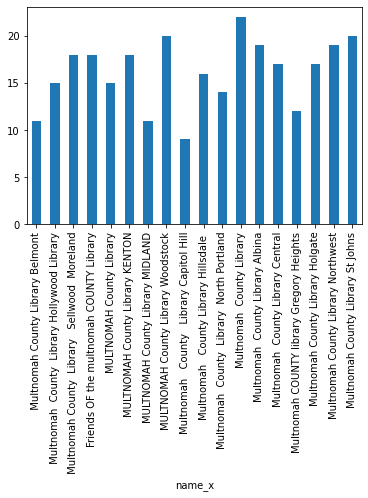

In [24]:
df = table2.groupby(['name_x'])['is_late'].sum()

df.plot.bar()

### The above plot shows the statistics of the count of times people have returned their books late categories by each library. From the data, we can see that Mulnomah county library has most number of late return recoeds while ML library Capitol Hill has the learst number of late returns 

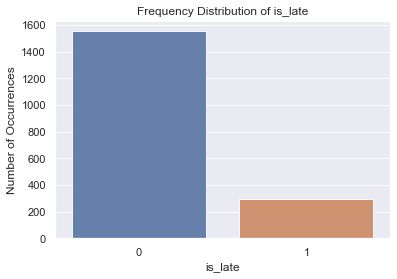

In [25]:
carrier_count = table2['is_late'].value_counts()
sns.set(style="darkgrid")
sns.barplot(carrier_count.index, carrier_count.values, alpha=0.9)
plt.title('Frequency Distribution of is_late')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('is_late', fontsize=12)
plt.show()

## Data Analysis, Feature Engineering and Model Building

In [26]:
##table2.loc[(table2['is_late']== 1) ].head(50)

In [27]:
##table2.loc[(table2['is_late']== 1) ].tail(50)

### Encoding categorical columns

In [28]:
def encode(col,df):
    le = LabelEncoder()
    le.fit(df[col].astype(str))
    df[col] = le.transform(df[col].astype(str))

In [29]:
cat = ["name_x","name_y","postal_code","gender","occupation","publisher","authors","education","title","categories"]
for i in cat:
    encode(i,table2)

### Selecting relevant columns

In [30]:

final_table = table2[["name_x","name_y","zipcode","gender","education","occupation","price","pages","age_group_number","legit","is_late"]]

### Train-test-validation splitting

In [31]:
x = final_table.drop(columns = "is_late")
y = final_table["is_late"]
x_train, x_test, y_train, y_test = train_test_split(x, y,train_size = 0.8, test_size=0.2, random_state=6788)

In [32]:
## Hold out validation for imbalanced dataset since the data is imbalanced
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, train_size = 0.9, test_size=0.1, random_state=15)

### Calculating how important a feature is in predicting depends variable (is_late)

In [33]:
final_table.isnull().sum()

name_x              0
name_y              0
zipcode             0
gender              0
education           0
occupation          0
price               0
pages               0
age_group_number    0
legit               0
is_late             0
dtype: int64

In [34]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=15, criterion = 'entropy', max_depth = 10)
dt.fit(x,y)
fi_col = []
fi = []

for i,column in enumerate(final_table.drop('is_late', axis = 1)):
    print('The feature importance for {} is : {}'.format(column, dt.feature_importances_[i]))
    
    fi_col.append(column)
    fi.append(dt.feature_importances_[i])

The feature importance for name_x is : 0.0865914592135917
The feature importance for name_y is : 0.1524465224088886
The feature importance for zipcode is : 0.16034702752052085
The feature importance for gender is : 0.03316496158287256
The feature importance for education is : 0.046890240663804976
The feature importance for occupation is : 0.060004603607530134
The feature importance for price is : 0.10846454724997244
The feature importance for pages is : 0.1584267820308752
The feature importance for age_group_number is : 0.04496747909275327
The feature importance for legit is : 0.14869637662919025


In [35]:
fi_col
fi

fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns = ['Feature','Feature Importance'])
fi_df


# Ordering the data
fi_df = fi_df.sort_values('Feature Importance', ascending = False).reset_index()

# Creating columns to keep
columns_to_keep = fi_df['Feature'][0:19]

fi_df.head(n=30)

,index,Feature,Feature Importance
0,2,zipcode,0.160347
1,7,pages,0.158427
2,1,name_y,0.152447
3,9,legit,0.148696
4,6,price,0.108465
5,0,name_x,0.086591
6,5,occupation,0.060005
7,4,education,0.046890
8,8,age_group_number,0.044967
9,3,gender,0.033165


## Model building and evalualting it

In [36]:
## Training a dummy classifiera
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)
score = dummy_clf.score(x_test, y_test)

pred_proba_t = dummy_clf.predict_proba(x_test)
log_loss2 = log_loss(y_test, pred_proba_t)

print("Testing Acc:", score)
print("Log Loss:", log_loss2)

Testing Acc: 0.8373983739837398
Log Loss: 5.616061202424501


In [37]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(x_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(x_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.84
Accuracy of Logistic regression classifier on test set: 0.84


In [38]:
log_reg = LogisticRegression(random_state=10, solver = 'lbfgs')

log_reg.fit(x_train, y_train)

# predict - Predict class labels for samples in X
log_reg.predict(x_train)
y_pred = log_reg.predict(x_train)

# predict_proba - Probability estimates
pred_proba = log_reg.predict_proba(x_train)

# coef_ - Coefficient of the features in the decision function
log_reg.coef_



array([[ 3.74032923e-04,  3.95074789e-04, -2.29720271e-05,
        -1.45057865e-04,  1.19831333e-04, -5.39002275e-03,
         1.28283097e-03,  6.43651051e-05, -3.02221197e-04,
         6.82043932e-04]])

In [39]:
# Accuracy on Train
print("The Training Accuracy is: ", log_reg.score(x_train, y_train))

# Accuracy on Test
print("The Testing Accuracy is: ", log_reg.score(x_test, y_test))


# Classification Report
print(classification_report(y_train, y_pred))

The Training Accuracy is:  0.8394875659382065
The Testing Accuracy is:  0.8373983739837398
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1114
           1       0.00      0.00      0.00       213

    accuracy                           0.84      1327
   macro avg       0.42      0.50      0.46      1327
weighted avg       0.70      0.84      0.77      1327



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Steps

1) First called all the csv files and merged it using primary key and foreign key as from the schema given. <br><br>
2) Data Cleaning: handles the null values, dropping columns not relevant, feature contruction like calculating age from dob which helps in knowing the demographics of the customer, encoding categorical values so that they can be used in model. Clearning columns like zipcode, pages, price as it contained garbage values like '|',"USD" and others<br><br>
3) Data visualization: To get insights from the data given below<br><br>
4) Data Analysis and Model builidng: Here I have used logisitic regression to build the model as it is a binary classification problem  (predicitng whether the customer has returned on time or not) and then finding out the reasons for the problem

## Insights from the data

1) Mulnomah county(MC) library has most number of late return records while ML library Capitol Hill has the least number of late returns 

2) Students in high schools have returned late as compared to others but the difference is not so significant

3) Books of cateogry Business & Economics have been returned late.

4) Books having more pages than have been returned late

In [40]:
Rate_of_late_return = round(table2["is_late"].sum()/table2.shape[0],2)
print("Rate_of_late_return :", Rate_of_late_return)

Rate_of_late_return : 0.16


16 out of 100 books issued have been returned late

## Recommendations

Factors which are affecting more in late returns are: Library location, price of the book, pages of the book and catgory of the books.


Also there are more number of return cases in MC library so the location might be far from the residential area but it would be difficult for people to commute. So maybe we should shift the location and get it more nearer to residential area/schools/colleges.

Also, books with more pages tend to be returned late so maybe for books more than 1000 pages, so we can increase the late-return span from 28 days to 35 days. 

For the books with high price, we can charge fees if returned late. This will prevent people from returning expensive books late.

## Next step

There are dummy values in date_issue where they issued book in the 1800 century so not sure how accurate is this. If we can handle this data or can get better data
we can get more accurate model which helps in knowing the reasons for late return

Data given is more of the year 2018, maybe we can get the data from other years and check if there is any tren or seasonality in the datea. Like maybe people are returning late more in the time like novemebr-decemebr when there is thanksgiving holidays, winter/christmas break. More maybe they refer the book for their exams and they return when the exam is over.

We can use various other techniques/ model for the analysis.

#### Note** I have not shows some of the steps or commented out as it contains the data which I am not suppose to discuss